In [69]:
#! pip install --quiet "tabulate" "ipython[notebook]>=8.0.0, <8.12.0" "pytorch-lightning>=1.4, <2.0.0" "torchvision" "setuptools==67.4.0" "seaborn" "torch>=1.8.1, <1.14.0" "matplotlib" "torchmetrics>=0.7, <0.12" "lightning>=2.0.0rc0"

### Why CNN'S
* ANN'S are not designed to process data like Images which have spatial information because we would need to flatten them which leads to a loss of spatial information
* CNN are equivariant meaning that the resultant feature map obtained by first augmenting and then performing convolution is the same as the one obtained by first performing convolution and then performing augmentation making them invariant to spatial transformation

### How they work
* Feature extractor - this component is responsible for performing convolution on images and extracting spatial information(edges, contour, eyes, nose)
    * Convolution Layer
        * Performs the convolution operation on the image to extract spatial information utilizing
            * Kernel - filter supposed to perform convolution on images. It is first randomly initialized but later updated through back propagation to extract the spatial features more accurately. We then do element-wise product and sum of the filter matrix and the original image
            * Stride - Number of pixels by which the kernel moves while performing convolution
            * Padding - Number of pixels by which the image is padded while performing convolution sice convolution on an image leads to a reduction in the image size. So we pad to preserve the image size
            * Kernel size - This is the size of the kernel which is used to perform the convolution on Images. Using a larger kernel size leads to faster training but loss of details in the image
            * Number of filters - this is the number of convolution filters which are convoluted on the images. Each filter is stacked along the channels
        
    * Activation Function
        * introduces non-linearity in the feature maps. This is done to enhance the learning process enabling the nn to learn more complex patterns

    * Pooling Layer
        * Pooling is donne to reduce the number of params that gradually increase due to repeated convolutions while preserving maximum information
        * Achieved by sliding a window(usually 2* 2 window) over the resultant feature map and picks up the pooled pixel in each window
        * Variants include:
            * Max Pooling - we pick up the pixel which has the maximum value in each pixel. Throws away all other non useful info
            * Min Pooling - We pick up the pixel which has the minimum value in each pooling window
            * Average Pooling - We average all the pixels in each pooling window. Retains much info about the less important elements of a block or pool
        
* Flattening - this component is responsible for converting the multi dimensional feature map to a 1D array which can later be processed by the classification head
* Classification Head - this component is composed of several fully connected layers which perform classification


### How do CNNs Learn
* They preserve the spatial information of the image by extracting the feature maps. By performing convolution using multiple filters the CNN learns a variety of spatial information like edges, shapes, objects e.t.c which are then flattened and passed to the classification head to predict the classes or the regression head to predict the desired quantity
    * Convolution + ReLU
    * max_pooling
    * fully_connected + ReLU
    * softmax



### Loss Functions in CNNS
* Image classification
    * Hinge Loss
    * Cross Entropy Loss
    
* Image regression:
    * MSE
    * MAE
    * Huber Loss
    
### Tricks to speed up training
* Use batch normalization
    * speeds up training
    * allows for a large learning rate
    * does not depend on weight initialization
    
* Use Global Average Pooling instead of Flatten to convert output to 1D
    * captures the information of the feature map in each channel by taking the average
    * Reduces the number of params required to train
    * So from (channels, width, height) the average is taken along each chaneel, so the resultant shape becomes (channels, 1,1) which can be reshaped into (channels, 1) and a classification head can be attached afterwards
   

### Lets build a CNN network

In [70]:
# !pip install matplotlib==3.6.1

In [71]:
# Import necessary libraries
import torch  # PyTorch library for deep learning
import torchvision  # PyTorch library for computer vision tasks
import torch.optim as optim  # PyTorch library for optimization algorithms
from torch.utils.data import DataLoader, Dataset  # PyTorch library for handling datasets and data loaders
from torch.utils.data import random_split  # PyTorch library for splitting datasets
import pickle  # Python library for serializing and deserializing Python objects
import numpy as np  # NumPy library for numerical computations
import matplotlib.pyplot as plt  # Matplotlib library for data visualization
import torchvision.transforms as transforms  # PyTorch library for image transformations
from torch.optim.lr_scheduler import StepLR  # PyTorch library for learning rate scheduling

In [72]:
#checking for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#### Setup and Data Preparation

In [134]:
# Define hyperparameters and settings
n_epochs = 3  # Number of epochs for training
batch_size_train = 64  # Batch size for training dataset
batch_size_test = 1000  # Batch size for testing dataset
learning_rate = 0.001  # Learning rate for optimization algorithm
momentum = 0.5  # Momentum parameter for optimization algorithm
log_interval = 10  # Interval for logging training progress
random_seed = 1  # Random seed for reproducibility
torch.backends.cudnn.enabled = False  # Disable CuDNN for deterministic results
torch.manual_seed(random_seed)  # Set random seed for PyTorch

In [135]:
# Pytorch Custom dataset to load data from pickle files
class CustomDataset(Dataset):
    def __init__(self, data_path, meta_path, transform=None):
        self.images = [] #list to store our images
        self.labels = [] #list to store the corresponding image labels
        self.transform = transform #image transformations initialization

         # Load batches.meta to get class names
        meta_file_path = f"{meta_path}.meta"
        with open(meta_file_path, 'rb') as f:
            meta_dict = pickle.load(f, encoding='bytes')
            self.class_names = [name.decode('utf-8') for name in meta_dict[b'label_names']]

        # Load all batches and concatenate them - there are 5 batches in our image data i.e data_batch_1, data_batch_1 etc.
        for i in range(1, 6):
            file_path = f"{data_path}_{i}"
            with open(file_path, 'rb') as f:
                data_dict = pickle.load(f, encoding='bytes')
            self.images.append(data_dict[b'data'])
            self.labels.extend(data_dict[b'labels'])
        self.images = np.concatenate(self.images, axis=0)

        #this function returns length/ number of images
    def __len__(self):
        return len(self.images)

        #this function is used to subset an individual image
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Reshape image to (3, 32, 32) format (channels, height, width)
        image = np.reshape(image, (3, 32, 32))
        # Convert to PyTorch tensor and normalize
        image = torch.tensor(image, dtype=torch.float32) / 255.0
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        # Convert label to PyTorch tensor
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [136]:
# Transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally with a probability of 0.5
    # transforms.RandomCrop(size=(32, 32)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomRotation(),
    # transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        # [0.5,0.5,0.5])
])

In [137]:
import os

# List files in the directory
files = os.listdir('/content')

# Print the list of files
print(files)


['.config', 'images.zip', 'images', 'model.pth', 'optimizer.pth', 'sample_data']


In [77]:
import zipfile

# Path to the zip file
zip_file_path = '/content/images.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/images')

In [138]:
# Load datasets
train_dataset = CustomDataset('/content/images/images/data_batch', '/content/images/images/batches', transform=transform)

In [148]:
# Define the lengths of training and testing sets
train_size = int(0.8 * len(train_dataset))  # 80% of the data for training
test_size = len(train_dataset) - train_size  # Remaining 20% for testing

# Split the dataset
train_set, test_set = random_split(train_dataset, [train_size, test_size])

In [149]:
#print both the shapes of train and test sets
train_set.__len__(), test_set.__len__()

(40000, 10000)

In [150]:
# Print the class names
print(train_dataset.class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [151]:
# Lets have a feel of the tensor object - image tensor and corresponding label
train_dataset.__getitem__(10)

(tensor([[[0.2078, 0.2118, 0.2196,  ..., 0.1843, 0.1608, 0.0941],
          [0.1804, 0.2078, 0.2118,  ..., 0.1647, 0.1529, 0.1098],
          [0.1765, 0.1961, 0.1804,  ..., 0.1490, 0.1412, 0.1137],
          ...,
          [0.2784, 0.2902, 0.3137,  ..., 0.2000, 0.1804, 0.1922],
          [0.2941, 0.3098, 0.3176,  ..., 0.2392, 0.2510, 0.1882],
          [0.3333, 0.3333, 0.3373,  ..., 0.2392, 0.2510, 0.1922]],
 
         [[0.2549, 0.2471, 0.2353,  ..., 0.2000, 0.1765, 0.1098],
          [0.2314, 0.2431, 0.2314,  ..., 0.1804, 0.1686, 0.1255],
          [0.2314, 0.2353, 0.2039,  ..., 0.1647, 0.1569, 0.1294],
          ...,
          [0.3255, 0.3255, 0.3333,  ..., 0.2118, 0.1922, 0.1961],
          [0.3216, 0.3333, 0.3333,  ..., 0.2549, 0.2627, 0.1961],
          [0.3255, 0.3294, 0.3373,  ..., 0.2549, 0.2627, 0.1961]],
 
         [[0.2078, 0.2039, 0.1961,  ..., 0.1961, 0.1725, 0.1059],
          [0.1608, 0.1765, 0.1725,  ..., 0.1765, 0.1647, 0.1216],
          [0.1490, 0.1608, 0.1333,  ...,

In [152]:
# List of class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Map numerical labels to class names
label_to_class = {i: class_name for i, class_name in enumerate(class_names)}
label_to_class

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

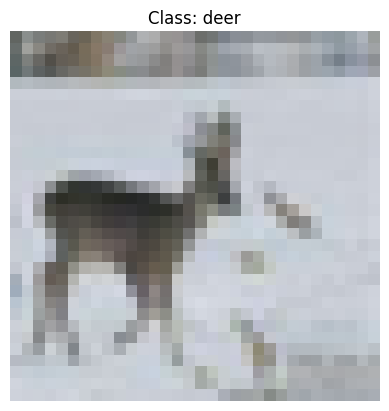

In [153]:
# # Extract image and label from dataset
image, label = train_dataset.__getitem__(20)

# # Convert image tensor to NumPy array and permute dimensions if necessary
image_np = image.permute(1, 2, 0).numpy() if image.dim() == 3 else image.numpy()

# # Plot the image
plt.imshow(image_np)
plt.title(f"Class: {class_names[label.item()]}")
plt.axis('off')
plt.show()

In [154]:
#check the object holding this image data
print(type(train_dataset))

<class '__main__.CustomDataset'>


In [155]:
#check the number of images we are working on
train_dataset.__len__()

50000

In [156]:
# Create train DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)

# Create test DataLoader
test_loader = DataLoader(test_set, batch_size=batch_size_train, shuffle=False)

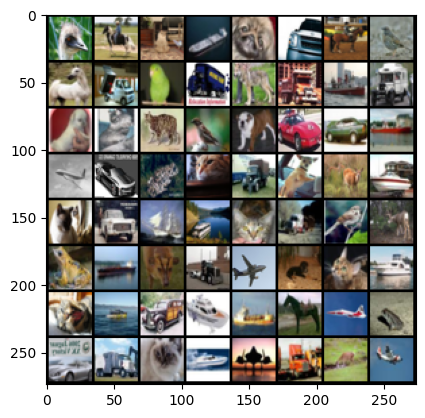

 bird horse   cat  ship   dog automobile horse  bird


In [160]:
#create a function to display sample images in a batch - 64 images
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get an iterator for the train_loader
dataiter = iter(train_loader)

# Get some random training images
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(8)))

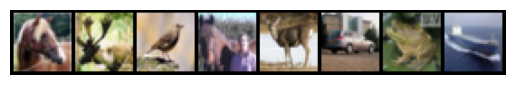

horse  deer  bird horse  deer automobile  frog  ship


In [165]:
# Create a function to display sample images in a batch - 64 images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Turn off axis
    plt.show()

# Get an iterator for the train_loader
dataiter = iter(train_loader)

# Get some random training images
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))  # Display first 8 images
# Print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(8)))  # Print labels of first 8 images


In [166]:
#shape of the iterable object - dataloader
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 3, 32, 32])

#### Building the Network

In [167]:
import torch.nn as nn #torch.nn layers contain trainable params
import torch.nn.functional as F #these ones are purely functional
import torch.optim as optim

#For readability
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3,32, kernel_size = 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)


        )
        self.flatten = nn.Flatten()

        self.classification_head = nn.Sequential(
            nn.Linear(6*6*64, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        #pass it to the feature extractor
        x = self.feature_extractor(x)
        #Flatten the output
        x = self.flatten(x)

        #forward pass through the classification layers
        x = self.classification_head(x)

        return F.log_softmax(x, dim=1)


#### Initialize the network and the optimizer

In [168]:
network = MyCNN()
optimizer = optim.SGD(network.parameters(),lr = learning_rate, momentum = momentum)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

#### Train the Network

In [169]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))



In [93]:
# Training loop
# for epoch in range(n_epochs):
#     train(epoch)
#     test()
#     scheduler.step()

In [170]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.3024, Accuracy: 1033/10000 (10%)

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.336529
Train Epoch: 1 [640/40000 (2%)]	Loss: 2.267973
Train Epoch: 1 [1280/40000 (3%)]	Loss: 2.291822
Train Epoch: 1 [1920/40000 (5%)]	Loss: 2.239784
Train Epoch: 1 [2560/40000 (6%)]	Loss: 2.217124
Train Epoch: 1 [3200/40000 (8%)]	Loss: 2.234206
Train Epoch: 1 [3840/40000 (10%)]	Loss: 2.217646
Train Epoch: 1 [4480/40000 (11%)]	Loss: 2.200058
Train Epoch: 1 [5120/40000 (13%)]	Loss: 2.213788
Train Epoch: 1 [5760/40000 (14%)]	Loss: 2.209646
Train Epoch: 1 [6400/40000 (16%)]	Loss: 2.223493
Train Epoch: 1 [7040/40000 (18%)]	Loss: 2.211034
Train Epoch: 1 [7680/40000 (19%)]	Loss: 2.141173
Train Epoch: 1 [8320/40000 (21%)]	Loss: 2.156988
Train Epoch: 1 [8960/40000 (22%)]	Loss: 2.087297
Train Epoch: 1 [9600/40000 (24%)]	Loss: 2.007386
Train Epoch: 1 [10240/40000 (26%)]	Loss: 2.145801
Train Epoch: 1 [10880/40000 (27%)]	Loss: 2.146568
Train Epoch: 1 [11520/40000 (29%)]	Loss: 2.053826
Train Epoch: 1 [12

### Evaluating the Model's Performance

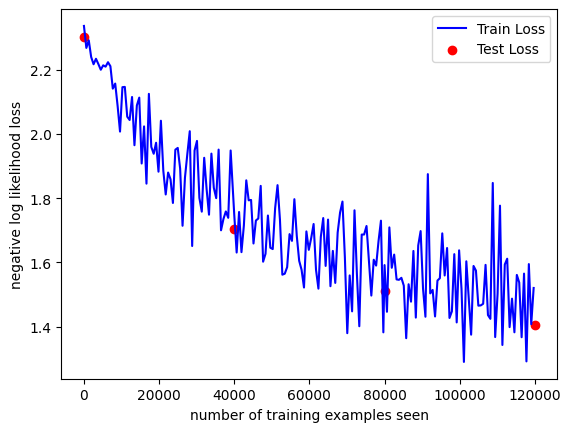

In [171]:
fig = plt.figure() # Create a new figure
plt.plot(train_counter, train_losses, color='blue') # Plot the training losses
plt.scatter(test_counter[:len(test_losses)], test_losses, color='red')  # Scatter plot for test losses with adjusted length of test_counter
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
# Set labels for axes
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()


#### Sample Prediction on our example dataset

In [172]:
# Perform inference without gradient calculation
with torch.no_grad():
  # Pass the example data through the network to get predictions
    output = network(example_data)

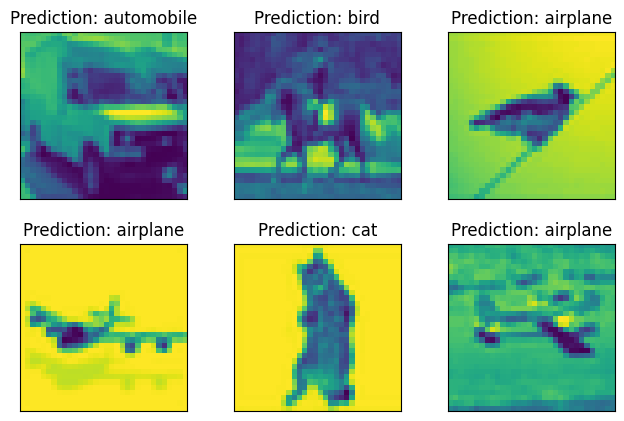

In [173]:
# Create a figure for displaying sample images and predictions
fig = plt.figure()
for i in range(6): # Iterate over the first 6 images in the example dataset
    plt.subplot(2, 3, i+1)
    # Create subplots with 2 rows and 3 columns, indexed from 1
    plt.tight_layout()

    # Display the image without interpolation
    plt.imshow(example_data[i][0], interpolation='none')

     # Get the predicted label for the current image
    pred_label = output.data.max(1, keepdim=True)[1][i].item()

     # Get the class name corresponding to the predicted label
    class_name = class_names[pred_label]
    plt.title("Prediction: {}".format(class_name))

    # Remove ticks on both axes
    plt.xticks([])
    plt.yticks([])

# Show the figure with the sample images and predictions
fig.show()

#### Load model from checkpoint and COntinue training your model further

In [174]:
# Create a new instance of the CNN model
continued_network = MyCNN()

# Initialize the optimizer with SGD and set the learning rate and momentum
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [175]:
# Load the saved state dictionary of the model from the checkpoint file
network_state_dict = torch.load("/content/model.pth")
continued_network.load_state_dict(network_state_dict)

# Load the saved state dictionary of the optimizer from the checkpoint file
optimizer_state_dict = torch.load("/content/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

In [176]:
# Iterate through a range of epochs and perform training and testing
for i in range(4,16):
  test_counter.append(i*len(train_loader.dataset))  # Record the number of training examples seen
  train(i) # Perform training for the current epoch
  test() # Perform testing after training for the current epoch

Train Epoch: 4 [0/40000 (0%)]	Loss: 1.327236
Train Epoch: 4 [640/40000 (2%)]	Loss: 1.527941
Train Epoch: 4 [1280/40000 (3%)]	Loss: 1.474829
Train Epoch: 4 [1920/40000 (5%)]	Loss: 1.488939
Train Epoch: 4 [2560/40000 (6%)]	Loss: 1.397300
Train Epoch: 4 [3200/40000 (8%)]	Loss: 1.651933
Train Epoch: 4 [3840/40000 (10%)]	Loss: 1.393809
Train Epoch: 4 [4480/40000 (11%)]	Loss: 1.473167
Train Epoch: 4 [5120/40000 (13%)]	Loss: 1.383285
Train Epoch: 4 [5760/40000 (14%)]	Loss: 1.387177
Train Epoch: 4 [6400/40000 (16%)]	Loss: 1.222961
Train Epoch: 4 [7040/40000 (18%)]	Loss: 1.635117
Train Epoch: 4 [7680/40000 (19%)]	Loss: 1.488153
Train Epoch: 4 [8320/40000 (21%)]	Loss: 1.214271
Train Epoch: 4 [8960/40000 (22%)]	Loss: 1.456545
Train Epoch: 4 [9600/40000 (24%)]	Loss: 1.323163
Train Epoch: 4 [10240/40000 (26%)]	Loss: 1.555277
Train Epoch: 4 [10880/40000 (27%)]	Loss: 1.454383
Train Epoch: 4 [11520/40000 (29%)]	Loss: 1.571296
Train Epoch: 4 [12160/40000 (30%)]	Loss: 1.467214
Train Epoch: 4 [12800/4000

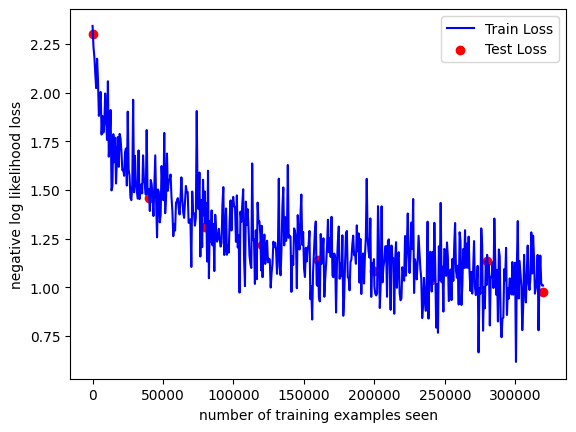

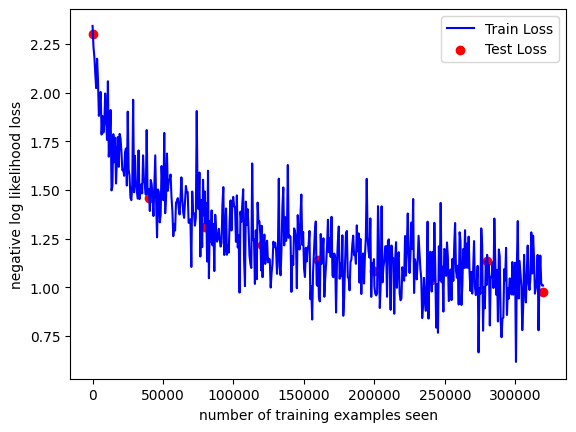

In [130]:
# Create a figure to visualize training and testing losses
fig = plt.figure()

# Plot training losses in blue
plt.plot(train_counter, train_losses, color='blue')

# Scatter plot testing losses in red
plt.scatter(test_counter, test_losses, color='red')

# Add legend to the plot
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')

# Add labels to the x and y axes
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

# Show the figure
fig